In [86]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as stats
from scipy.stats.mstats import winsorize
from sqlalchemy import create_engine
import warnings

warnings.filterwarnings('ignore')
sns.set(style="whitegrid")
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 100)

In [2]:
postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'useducation'

engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))

data = pd.read_sql_query('select * from useducation',con=engine)

# no need for an open connection, 
# as we're only doing a single query
engine.dispose()

In [3]:
data.head()

,PRIMARY_KEY,STATE,YEAR,ENROLL,TOTAL_REVENUE,FEDERAL_REVENUE,STATE_REVENUE,LOCAL_REVENUE,TOTAL_EXPENDITURE,INSTRUCTION_EXPENDITURE,...,GRADES_4_G,GRADES_8_G,GRADES_12_G,GRADES_1_8_G,GRADES_9_12_G,GRADES_ALL_G,AVG_MATH_4_SCORE,AVG_MATH_8_SCORE,AVG_READING_4_SCORE,AVG_READING_8_SCORE
0,1992_ALABAMA,ALABAMA,1992,NaN,2678885.0,304177.0,1659028.0,715680.0,2653798.0,1481703.0,...,57948.0,58025.0,41167.0,471564.0,196386.0,676174.0,208.327876,252.187522,207.963517,NaN
1,1992_ALASKA,ALASKA,1992,NaN,1049591.0,106780.0,720711.0,222100.0,972488.0,498362.0,...,9748.0,8789.0,6714.0,79117.0,30847.0,112335.0,NaN,NaN,NaN,258.859712
2,1992_ARIZONA,ARIZONA,1992,NaN,3258079.0,297888.0,1369815.0,1590376.0,3401580.0,1435908.0,...,55433.0,49081.0,37410.0,437127.0,175210.0,614881.0,215.253932,265.366278,206.212716,262.169895
3,1992_ARKANSAS,ARKANSAS,1992,NaN,1711959.0,178571.0,958785.0,574603.0,1743022.0,964323.0,...,34632.0,36011.0,27651.0,281338.0,123113.0,405259.0,210.206028,256.312090,208.634458,264.619665
4,1992_CALIFORNIA,CALIFORNIA,1992,NaN,26260025.0,2072470.0,16546514.0,7641041.0,27138832.0,14358922.0,...,418418.0,363296.0,270675.0,3286034.0,1372011.0,4717112.0,208.398961,260.892247,196.764414,NaN


In [5]:
len(data.columns)

25

## Dealing with missing values

In [7]:
data.isnull().sum()/data.isnull().count()

PRIMARY_KEY                     0.000000
STATE                           0.000000
YEAR                            0.000000
ENROLL                          0.176273
TOTAL_REVENUE                   0.142091
FEDERAL_REVENUE                 0.142091
STATE_REVENUE                   0.142091
LOCAL_REVENUE                   0.142091
TOTAL_EXPENDITURE               0.142091
INSTRUCTION_EXPENDITURE         0.142091
SUPPORT_SERVICES_EXPENDITURE    0.142091
OTHER_EXPENDITURE               0.176273
CAPITAL_OUTLAY_EXPENDITURE      0.142091
GRADES_PK_G                     0.115952
GRADES_KG_G                     0.088472
GRADES_4_G                      0.087802
GRADES_8_G                      0.087802
GRADES_12_G                     0.087802
GRADES_1_8_G                    0.087802
GRADES_9_12_G                   0.087802
GRADES_ALL_G                    0.115952
AVG_MATH_4_SCORE                0.640751
AVG_MATH_8_SCORE                0.643432
AVG_READING_4_SCORE             0.642761
AVG_READING_8_SC

Clearly, filling in the missing values with the population median/means will distort the data, so we will interpolate using a specific `STATE`'s data. The remaining NaN values will be filled in with the mean of the year before and after. 

In [10]:
data.loc[data['STATE'] == 'CALIFORNIA'].head(10)

,PRIMARY_KEY,STATE,YEAR,ENROLL,TOTAL_REVENUE,FEDERAL_REVENUE,STATE_REVENUE,LOCAL_REVENUE,TOTAL_EXPENDITURE,INSTRUCTION_EXPENDITURE,...,GRADES_4_G,GRADES_8_G,GRADES_12_G,GRADES_1_8_G,GRADES_9_12_G,GRADES_ALL_G,AVG_MATH_4_SCORE,AVG_MATH_8_SCORE,AVG_READING_4_SCORE,AVG_READING_8_SCORE
4,1992_CALIFORNIA,CALIFORNIA,1992,NaN,26260025.0,2072470.0,16546514.0,7641041.0,27138832.0,14358922.0,...,418418.0,363296.0,270675.0,3286034.0,1372011.0,4717112.0,208.398961,260.892247,196.764414,NaN
56,1993_CALIFORNIA,CALIFORNIA,1993,5129788.0,28043338.0,2151157.0,17064146.0,8828035.0,28110986.0,15281147.0,...,420233.0,380223.0,277271.0,3328627.0,1393530.0,4782111.0,NaN,NaN,NaN,NaN
108,1994_CALIFORNIA,CALIFORNIA,1994,4120498.0,23440845.0,2095878.0,13175550.0,8169417.0,23012688.0,12443864.0,...,426919.0,388561.0,285132.0,3372294.0,1421547.0,4860291.0,NaN,NaN,NaN,NaN
161,1995_CALIFORNIA,CALIFORNIA,1995,5299405.0,29512214.0,2612241.0,15541486.0,11358487.0,30097549.0,16146416.0,...,428553.0,399039.0,287428.0,3430751.0,1464841.0,4964774.0,NaN,NaN,NaN,NaN
213,1996_CALIFORNIA,CALIFORNIA,1996,5460484.0,31282981.0,2603882.0,17061474.0,11617625.0,31561692.0,16880730.0,...,435217.0,406456.0,298669.0,3516572.0,1525618.0,5115423.0,209.129083,262.772478,201.912591,269.197451
264,1997_CALIFORNIA,CALIFORNIA,1997,5595836.0,35614934.0,2850766.0,20560730.0,12203438.0,33862281.0,18160435.0,...,451069.0,412604.0,317595.0,3591033.0,1578929.0,5246546.0,NaN,NaN,NaN,NaN
316,1998_CALIFORNIA,CALIFORNIA,1998,5727224.0,39183018.0,3149260.0,22840500.0,13193258.0,38087666.0,20083913.0,...,462241.0,424768.0,334852.0,3666271.0,1627284.0,5375481.0,NaN,NaN,NaN,NaN
367,1999_CALIFORNIA,CALIFORNIA,1999,5839207.0,41393435.0,3599923.0,23695095.0,14098417.0,40834643.0,21110543.0,...,489356.0,431730.0,347914.0,3734997.0,1675778.0,5496767.0,NaN,NaN,NaN,NaN
420,2000_CALIFORNIA,CALIFORNIA,2000,5941946.0,46628207.0,4024940.0,26877920.0,15725347.0,45829753.0,23514388.0,...,489043.0,441877.0,357789.0,3804640.0,1707952.0,5602511.0,213.565125,262.171027,205.916588,264.494066
472,2001_CALIFORNIA,CALIFORNIA,2001,6045030.0,53288943.0,4280358.0,31374889.0,17633696.0,52082540.0,26641811.0,...,485301.0,461133.0,365907.0,3871843.0,1745295.0,5717489.0,NaN,NaN,NaN,NaN


In [275]:
data2 = data.copy()
print(id(data), id(data2))

112226193488 112537427408


In [276]:
years = list(data2['YEAR'].unique())
years.sort(reverse = True)

In [277]:
for state in data2['STATE'].unique():
    data2.loc[data2['STATE'] == state] = data2.loc[data2['STATE'] == state].interpolate()
    
data2['YEAR'].loc[data2.isna().any(axis = 1)].value_counts()

1992    56
1993    49
1994    49
1995    49
1996    26
1997    26
1998    26
1999    26
2001    15
2000    14
2002    14
2003     8
2004     8
2005     8
2006     8
2007     8
2009     7
2011     7
2012     7
2013     7
2015     6
2010     6
2016     6
2008     5
2014     5
Name: YEAR, dtype: int64

In [280]:
for state in data2['STATE'].unique():
    for year in years:
        cols_with_nans = data2.loc[(data2['YEAR'] == year) & (
            data2['STATE'] == state)].isna().any()
        cols_with_nans = list(cols_with_nans.loc[cols_with_nans == True].index)

        try:
            if len(cols_with_nans) > 0:
                for col in cols_with_nans:
                    if year > 1992 & year < 2017:  # first year on record
                        before = data2[col].loc[(
                            data2['YEAR'] == year - 1) & (data2['STATE'] == state)].values[0]
                        after = data2[col].loc[(
                            data2['YEAR'] == year + 1) & (data2['STATE'] == state)].values[0]

                        before_after_mean = np.nanmean([before, after])

                        data2[col].loc[(data2['YEAR'] == year) & (data2['STATE']
                                                                      == state)] = before_after_mean
                    if year == 1992:            
                        value_1993 = data2[col].loc[(data2['YEAR'] == 1993) & (data2['STATE']
                                                                      == state)].values[0]
                        data2[col].loc[(data2['YEAR'] == year) & (data2['STATE']
                                                                      == state)] = value_1993
                        
        except IndexError:
            pass

In [283]:
data2['YEAR'].loc[data2.isna().any(axis = 1)].value_counts()

2003    8
1999    8
2007    8
2006    8
2005    8
2004    8
2002    8
2001    8
2000    8
2013    7
2012    7
2011    7
2009    7
1998    7
1996    6
1997    6
2015    6
2010    6
2014    5
2008    5
1995    5
1994    5
1993    5
1992    5
Name: YEAR, dtype: int64

We drop the remaining NaN rows.

In [285]:
data2.dropna(inplace=True)
data2.isnull().sum()/data2.isnull().count()

PRIMARY_KEY                     0.0
STATE                           0.0
YEAR                            0.0
ENROLL                          0.0
TOTAL_REVENUE                   0.0
FEDERAL_REVENUE                 0.0
STATE_REVENUE                   0.0
LOCAL_REVENUE                   0.0
TOTAL_EXPENDITURE               0.0
INSTRUCTION_EXPENDITURE         0.0
SUPPORT_SERVICES_EXPENDITURE    0.0
OTHER_EXPENDITURE               0.0
CAPITAL_OUTLAY_EXPENDITURE      0.0
GRADES_PK_G                     0.0
GRADES_KG_G                     0.0
GRADES_4_G                      0.0
GRADES_8_G                      0.0
GRADES_12_G                     0.0
GRADES_1_8_G                    0.0
GRADES_9_12_G                   0.0
GRADES_ALL_G                    0.0
AVG_MATH_4_SCORE                0.0
AVG_MATH_8_SCORE                0.0
AVG_READING_4_SCORE             0.0
AVG_READING_8_SCORE             0.0
dtype: float64

## Dealing with outliers

We pick 2 sample to understand what variables might contain outliers: MI, CO, FL, and NV.

In [310]:
cols = list(data2.columns)
cols.remove('STATE')
cols.remove('PRIMARY_KEY')

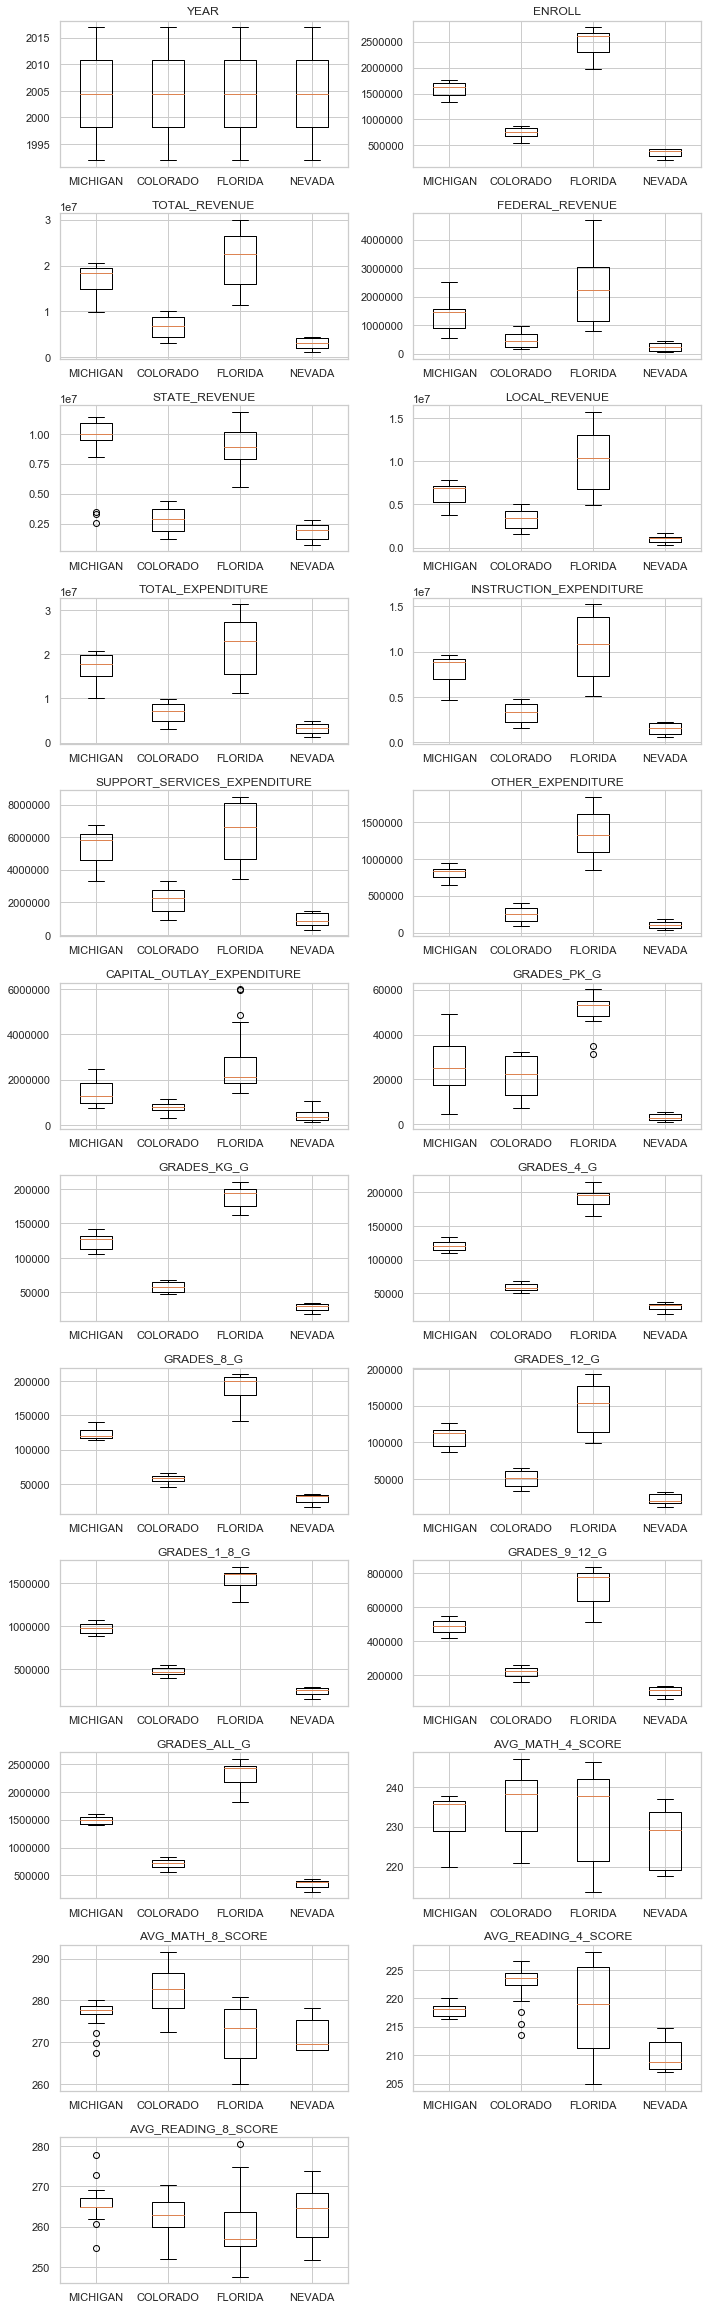

In [337]:
plt.figure(figsize=(10, 40))

states = ['MICHIGAN', 'COLORADO', 'FLORIDA', 'NEVADA']

for index, col in enumerate(cols):
    plt.subplot(15, 2, index + 1)

    x = [data2[col].loc[data2['STATE'] == state] for state in states]
    
    plt.boxplot(x, labels=states)
    plt.title(col)

plt.tight_layout()

We notice that the `AVG_READING_8_SCORE`, `AVG_READING_4_SCORE`, and `STATE_REVENUE` variables might contain outliers, so we explore this further.

In [375]:
data2['AVG_READING_4_SCORE'][data2['STATE'] == 'CALIFORNIA'].head()

4      196.764414
56     198.051458
108    199.338502
161    200.625547
213    201.912591
Name: AVG_READING_4_SCORE, dtype: float64

KeyError: (1992, 'AVG_READING_8_SCORE')

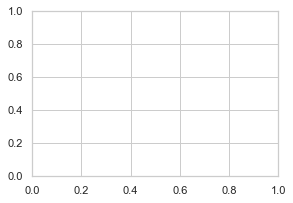

In [386]:
plt.figure(figsize=(15, 65))

for index, state in enumerate(data2['STATE'].unique()):
    plt.subplot(18, 3, index + 1)

    cols_of_interest = ['AVG_READING_8_SCORE', 'AVG_READING_4_SCORE']
   
    for year in data2['YEAR'].loc[(data2['STATE'] == state)].unique():
        for col in cols_of_interest:
                plt.plot(data2[year, col].loc[(data2['STATE'] == state) & (data2['YEAR'] == year)], label = col)
                plt.scatter(y = np.median(data2[col].loc[data2['YEAR'] == year]), x = year, label = col)

    plt.title(state)
plt.tight_layout()
